# Kalman Filter - Lab 7 
#### Iris R Seaman

In [3]:
%matplotlib inline
import skimage
import scipy 
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import scipy.misc
import scipy.io
DOT = np.dot
T = np.transpose
INV = np.linalg.pinv
import seaborn
import skimage.feature

# Loading Data Part 1

In [2]:
data_mat = scipy.io.loadmat('kfdata.mat')
#Observations (actual noisy data)
data = data_mat['data']
true_data = data_mat['true_data']
# data shape is (56, 2)

In [4]:
#Function to get covariances
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

# Initialize Parameters for Part 1

In [4]:
# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

# idenity matrix
I = np.eye( 6 )

In [5]:
print A

[[ 1.   0.   1.   0.   0.5  0. ]
 [ 0.   1.   0.   1.   0.   0.5]
 [ 0.   0.   1.   0.   1.   0. ]
 [ 0.   0.   0.   1.   0.   1. ]
 [ 0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   1. ]]


# Kalman Filter Function

In [6]:
def kalman_filter(mu_t, sigma_t, y_t):
    mu_t_1 = mu_t
    sigma_t_1 = sigma_t

    # predicted mu at t
    mu_t_p = DOT(A, mu_t_1)
    # predicted sigma at t
    sigma_t_p = DOT(A, DOT(sigma_t_1, T(A))) + Q

    # kalman gain
    K_gain_S_t = DOT(C, DOT(sigma_t_p, T(C))) + R
    K_gain = DOT(sigma_t_p, DOT(T(C), INV(K_gain_S_t)))
  
    # update mu
    mu_t = mu_t_p + DOT(K_gain, (y_t - DOT(C, mu_t_p)))
    # updated sigma
    sigma_t = DOT((I - DOT(K_gain, C)), sigma_t_p)
    
    return mu_t, sigma_t



# P1: KALMAN FILTER IN ACTION (updating each iteration)

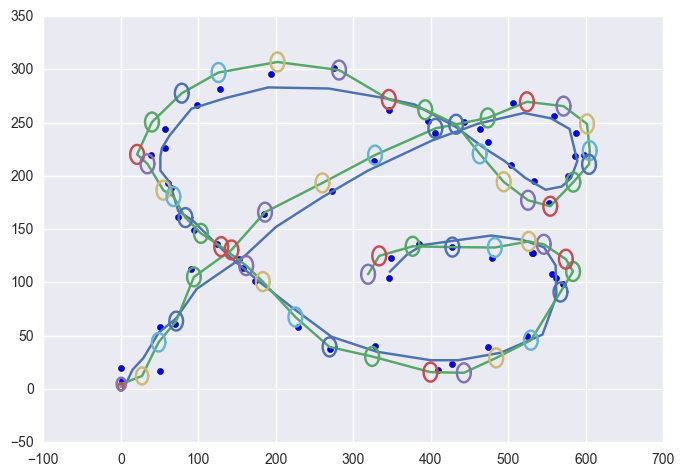

In [7]:
# RUNNING KALMAN FILTER
x = []
y = []
covarance = []
for y_t in data:
    mu_t, sigma_t = kalman_filter(mu_t, sigma_t, (y_t).reshape(2,1))
    x.append(mu_t[0,0])
    y.append(mu_t[1,0])
    covarance.append(sigma_t[:2,:2])

#PLOTING RESULTS
plt.plot(T(true_data)[0], T(true_data)[1])
plt.plot(x, y)
plt.scatter(T(data)[0], T(data)[1])

for i in xrange(len(covarance)):
    x_, y_ = cov_to_pts(covarance[i])
    plt.plot(x_ + x[i], y_ + y[i])

# Loading Data for Part 2

In [8]:
tmp = scipy.io.loadmat('ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template
 
data = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    data.append( maxloc )  # record the results
    
data = np.asarray( data )

# Initializing Parameters Part 2

In [19]:
# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 0, 0.5, 0, 0 ],
    [ 0, 1, 0, 0, 0.5, 0 ],
    [ 0, 0, 1, 0, 0, 0.5 ],
    [ 0, 0, 0, 1, 0, 0 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 5e-2 * np.eye( 6 )

# our observation noise
R = 150 * np.eye( 2 )
 
# initial state
mu_t = np.zeros(( 6, 1 ))
sigma_t = np.eye( 6 )

mu_t[0,0] = 200
mu_t[1,0] = 300
mu_t[2,0] = .005
mu_t[3,0] = .005
mu_t[4,0] = .005
mu_t[5,0] = .005



# REASONS FOR CHOSEN PARAMETERS (P2)

* I picked up Q for the same reason. But just a little bit. 

* I decided to start my initializations at a good approximation to help.  Therefore, I updated my approximate positions in mu_t and gave non-zeros to velocity and accelation

* As for Maxrix A, it made more sense to me to have the change of time between frames be represented in there. So I moved the 0.5 to a different diagonal, and elimated the extra diagonal of 1s

# P2: KALMAN FILTER IN ACTION (updating ea. iteration)

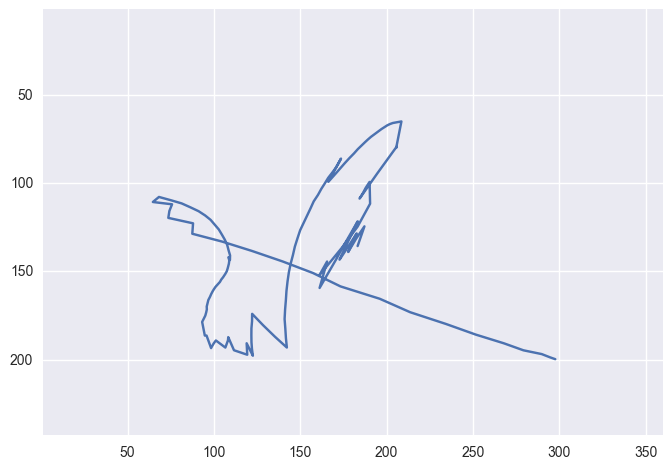

In [20]:
x = []
y = []
covarance = []

for y_t in data:
    mu_t, sigma_t = kalman_filter(mu_t, sigma_t, (y_t).reshape(2,1))
    x.append(mu_t[0,0])
    y.append(mu_t[1,0])
    covarance.append(sigma_t[:2,:2])
    
plt.figure(1)
plt.xlim([1, 360])
plt.ylim([243,1])
plt.plot(y, x)
#plt.plot( data[:,1], data[:,0] )
plt.show()

# Show visualizations for frames 54, 56, 78, 106, and 107

In [11]:
def plot_frame(t=54):
    tmp = np.reshape( frames[:,t], (360,243) ).T

    plt.figure(1)
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( data[t][1], data[t][0], c="r", label ="True Data")
    plt.scatter( y[t], x[t] )

    foo = cov_to_pts( covarance[t])

    plt.plot( foo[0,:] + y[t], foo[1,:] +  x[t] )
    plt.xlim([1, 360])
    plt.ylim([243,1])

## Legend:
*Red dot - observed data.
*Blue dot - my estimation.

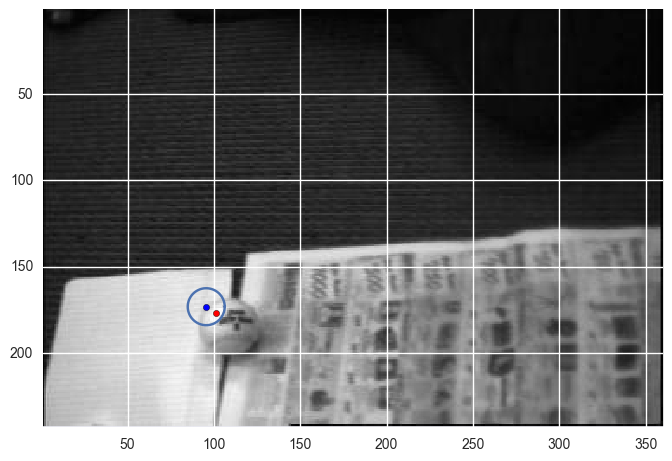

In [12]:
plot_frame(54)

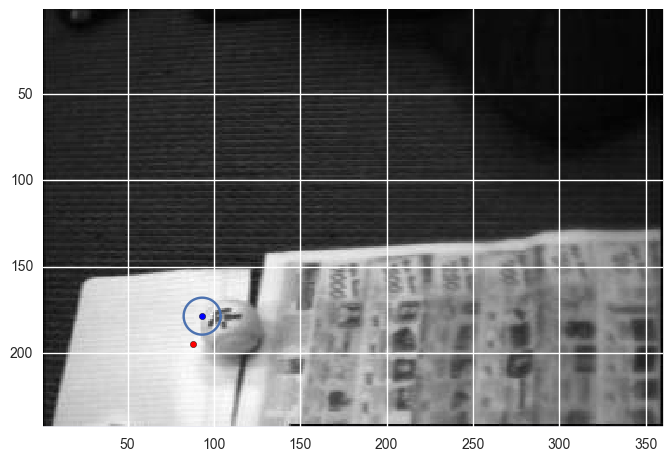

In [13]:
plot_frame(56)

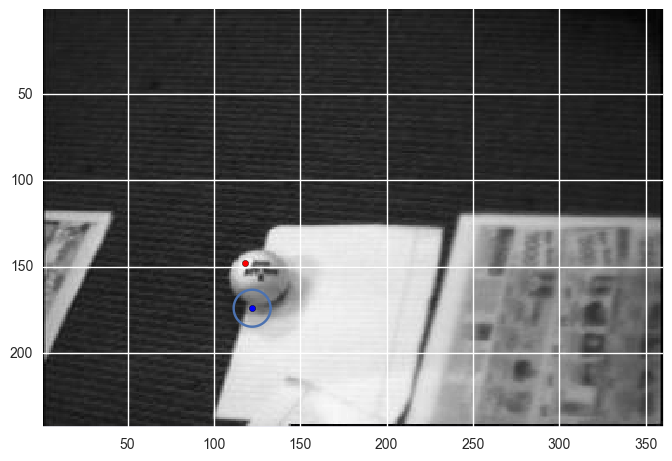

In [14]:
plot_frame(78)

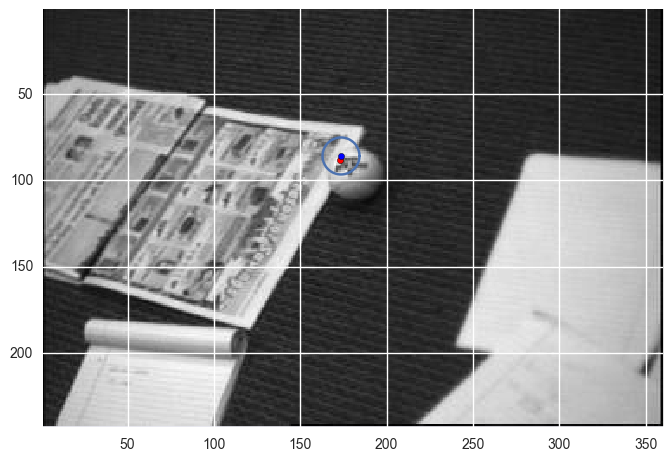

In [15]:
plot_frame(106)

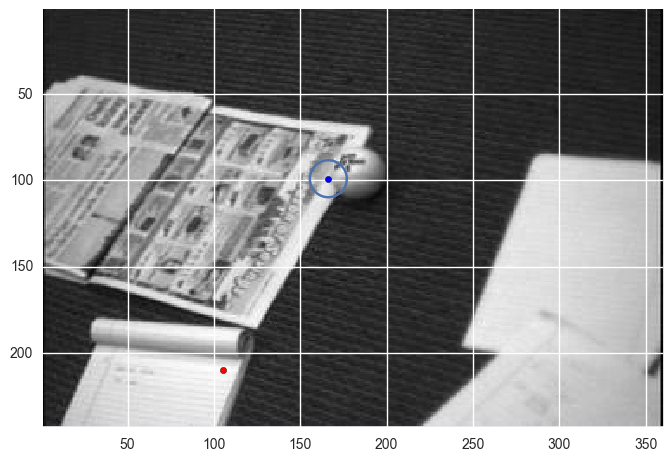

In [16]:
plot_frame(107)